In [1]:
import os
import numpy as np
import torch

In [3]:
from utils import load_model

# Load the pre-trained model
model, _ = load_model('pretrained/tsp_100/')
model.eval()  # Put in evaluation mode to not track gradients

# Generate random coordinates for 100 nodes
xy = np.random.rand(100, 2)

def make_oracle(model, xy, temperature=1.0):
    """
    Create an oracle function that returns the probabilities of the next node
    given the current tour using the model.
    """
    
    num_nodes = len(xy)
    
    # Convert coordinates to a tensor and add batch dimension
    xyt = torch.tensor(xy).float()[None]
    
    with torch.no_grad():  # Inference only
        # Get embeddings for the nodes
        embeddings, _ = model.embedder(model._init_embed(xyt))

        # Precompute keys and values for the glimpse and logits
        fixed = model._precompute(embeddings)
    
    def oracle(tour):
        """
        Given the current tour, return the probabilities of the next node.
        """
        with torch.no_grad():  # Inference only
            # Convert tour to tensor
            tour = torch.tensor(tour).long()
            if len(tour) == 0:
                # If tour is empty, use placeholder
                step_context = model.W_placeholder
            else:
                # Use embeddings of the first and last nodes in the tour
                step_context = torch.cat((embeddings[0, tour[0]], embeddings[0, tour[-1]]), -1)

            # Compute query for the current step
            query = fixed.context_node_projected + model.project_step_context(step_context[None, None, :])

            # Create mask for nodes already in the tour
            mask = torch.zeros(num_nodes, dtype=torch.uint8) > 0
            mask[tour] = 1
            mask = mask[None, None, :]  # Add batch and step dimension

            # Compute logits and probabilities
            log_p, _ = model._one_to_many_logits(query, fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key, mask)
            p = torch.softmax(log_p / temperature, -1)[0, 0]
            assert (p[tour] == 0).all()  # Ensure probabilities for visited nodes are zero
            assert (p.sum() - 1).abs() < 1e-5  # Ensure probabilities sum to 1
        return p.numpy()
    
    return oracle

# Create the oracle function
oracle = make_oracle(model, xy)

# Initialize variables for the tour
sample = False
tour = []
tour_p = []

# Construct the tour
while len(tour) < len(xy):
    # Get probabilities for the next node
    p = oracle(tour)
    
    if sample:
        # Sample next node using Gumbel-Max trick
        g = -np.log(-np.log(np.random.rand(*p.shape)))
        i = np.argmax(np.log(p) + g)
    else:
        # Select next node greedily
        i = np.argmax(p)
    
    # Add selected node to the tour
    tour.append(i)
    tour_p.append(p)
    
# Print the final tour
print([x.item() for x in tour])

  [*] Loading model from pretrained/tsp_100/epoch-99.pt
[73, 67, 91, 13, 22, 98, 92, 76, 41, 59, 25, 77, 56, 28, 34, 99, 90, 10, 51, 55, 75, 84, 36, 32, 70, 63, 82, 44, 23, 40, 96, 8, 27, 31, 94, 5, 78, 26, 1, 69, 18, 19, 42, 14, 35, 15, 71, 2, 24, 29, 3, 97, 21, 7, 88, 53, 79, 95, 62, 0, 93, 61, 38, 37, 81, 52, 4, 89, 85, 12, 43, 72, 47, 16, 54, 9, 39, 50, 68, 49, 11, 30, 20, 33, 65, 66, 58, 48, 6, 83, 57, 86, 46, 45, 60, 87, 64, 80, 17, 74]


In [12]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import numpy as np

def calculate_distance_matrix(coordinates):
    """Tính ma trận khoảng cách giữa các tọa độ."""
    num_points = len(coordinates)
    distance_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distance_matrix[i][j] = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
    return distance_matrix

def tsp_with_ortools(coordinates):
    """Giải bài toán TSP với OR-Tools."""
    # Tính ma trận khoảng cách
    distance_matrix = calculate_distance_matrix(coordinates)

    # Chuyển đổi ma trận khoảng cách thành số nguyên bằng cách nhân với hằng số
    scale_factor = 10**6
    distance_matrix = (distance_matrix * scale_factor).astype(int)

    # Số lượng điểm
    num_points = len(distance_matrix)

    # Tạo RoutingIndexManager và RoutingModel
    manager = pywrapcp.RoutingIndexManager(num_points, 1, 0)  # 1 xe, xuất phát tại điểm 0
    routing = pywrapcp.RoutingModel(manager)

    # Hàm chi phí (khoảng cách giữa hai điểm)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    # Gắn hàm chi phí
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Cấu hình tìm kiếm
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Giải bài toán
    solution = routing.SolveWithParameters(search_parameters)

    # Trả về kết quả
    if solution:
        # Trích xuất hành trình
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Quay lại điểm xuất phát
        return route, solution.ObjectiveValue() / scale_factor  # Chia lại scale_factor để đưa về giá trị ban đầu
    else:
        print("Không tìm thấy lời giải!")
        return None, None

# Tọa độ ví dụ
coordinates = xy

# Giải bài toán
route, objective_value = tsp_with_ortools(coordinates)

# Kết quả
if route:
    print("Lộ trình tối ưu:", route)
    print("Chi phí (khoảng cách):", objective_value)

Lộ trình tối ưu: [0, 79, 53, 95, 62, 38, 37, 3, 97, 88, 21, 7, 63, 70, 32, 36, 84, 75, 55, 51, 82, 10, 90, 99, 34, 28, 56, 77, 25, 59, 41, 92, 76, 31, 94, 27, 8, 40, 23, 44, 29, 24, 2, 52, 81, 4, 89, 9, 39, 35, 15, 71, 96, 5, 78, 26, 80, 17, 98, 22, 13, 91, 67, 73, 74, 87, 64, 60, 1, 57, 83, 6, 48, 58, 66, 65, 33, 20, 11, 30, 86, 45, 69, 18, 19, 14, 42, 46, 49, 68, 50, 54, 16, 47, 72, 43, 85, 12, 61, 93, 0]
Chi phí (khoảng cách): 8.366755


In [19]:
import numpy as np
import elkai

def calculate_distance_matrix(coordinates):
    """Tính ma trận khoảng cách giữa các tọa độ."""
    num_points = len(coordinates)
    distance_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distance_matrix[i][j] = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
    return distance_matrix

def tsp_with_elkai(coordinates):
    """Giải bài toán TSP với thư viện elkai."""
    # Tính ma trận khoảng cách
    distance_matrix = calculate_distance_matrix(coordinates)

    # Chuyển ma trận thành số nguyên
    scale_factor = 10**6
    distance_matrix_int = (distance_matrix * scale_factor).astype(int)

    # Chuyển ma trận về dạng danh sách cho elkai
    distance_matrix_list = distance_matrix_int.tolist()

    # Giải bài toán TSP
    route = elkai.solve_int_matrix(distance_matrix_list)

    # Tính tổng chi phí
    total_cost = 0
    for i in range(len(route) - 1):
        total_cost += distance_matrix[route[i]][route[i + 1]]
    total_cost += distance_matrix[route[-1]][route[0]]  # Quay lại điểm xuất phát

    return route, total_cost

# Tọa độ ví dụ
coordinates = xy

# Giải bài toán
route, total_cost = tsp_with_elkai(coordinates)

# Kết quả
if route:
    print("Lộ trình tối ưu:", route)
    print("Chi phí (khoảng cách):", total_cost)


Lộ trình tối ưu: [0, 93, 61, 12, 85, 89, 4, 9, 39, 54, 16, 43, 72, 47, 50, 68, 49, 11, 30, 20, 33, 65, 66, 58, 48, 6, 83, 57, 86, 45, 46, 42, 14, 35, 15, 71, 19, 18, 69, 1, 60, 64, 87, 74, 73, 67, 91, 13, 22, 98, 17, 80, 26, 78, 5, 96, 40, 23, 8, 27, 94, 31, 76, 92, 41, 59, 25, 77, 56, 28, 34, 99, 90, 10, 51, 55, 75, 84, 36, 32, 70, 63, 82, 44, 29, 24, 2, 52, 81, 38, 37, 3, 97, 21, 7, 88, 53, 95, 62, 79]
Chi phí (khoảng cách): 8.02324207741519


In [29]:
types = 20

In [34]:
import time
import pandas as pd
import warnings

warnings.filterwarnings("ignore")


# Benchmarking function
def benchmark_solver(solver_func, coordinates):
    start_time = time.time()
    route, cost = solver_func(coordinates)
    end_time = time.time()
    return {
        "Solver": solver_func.__name__,
        "Cost": cost,
        "Time (s)": end_time - start_time,
    }





def solve_with_attention_model(coordinates):
    oracle = make_oracle(model, coordinates)
    sample = True
    tour = []
    tour_p = []
    while len(tour) < len(coordinates):
        # Get probabilities for the next node
        p = oracle(tour)
        if sample:
            # Sample next node using Gumbel-Max trick
            g = -np.log(-np.log(np.random.rand(*p.shape)))
            i = np.argmax(np.log(p) + g)
        else:
            # Select next node greedily
            i = np.argmax(p)
        # Add selected node to the tour
        tour.append(i)
        tour_p.append(p)
    return tour, sum(
        np.linalg.norm(coordinates[tour[i]] - coordinates[tour[i - 1]])
        for i in range(1, len(tour))
    )


# Benchmark OR-Tools
def solve_with_ortools(coordinates):
    route, cost = tsp_with_ortools(coordinates)
    return route, cost


# Benchmark Elkai
def solve_with_elkai(coordinates):
    route, cost = tsp_with_elkai(coordinates)
    return route, cost


# Generate multiple instances and calculate average results
num_instances = 50
res = pd.DataFrame()
for type in [20, 50, 100]:
    all_results = []
    # Benchmark Attention Model
    model, _ = load_model(f"pretrained/tsp_{type}/")
    model.eval()  # Put in evaluation mode to not track gradients
    for _ in range(num_instances):
        coordinates = np.random.rand(type, 2)
        instance_results = []
        instance_results.append(
            benchmark_solver(solve_with_attention_model, coordinates)
        )
        instance_results.append(benchmark_solver(solve_with_ortools, coordinates))
        instance_results.append(benchmark_solver(solve_with_elkai, coordinates))
        all_results.extend(instance_results)
    average_result = pd.DataFrame(all_results).groupby("Solver").mean().reset_index()
    print(average_result)

  [*] Loading model from pretrained/tsp_20/epoch-99.pt
                       Solver      Cost  Time (s)
0  solve_with_attention_model  3.607439  0.010069
1            solve_with_elkai  3.838948  0.039563
2          solve_with_ortools  3.862418  0.008351
  [*] Loading model from pretrained/tsp_50/epoch-99.pt
                       Solver      Cost  Time (s)
0  solve_with_attention_model  5.605205  0.023224
1            solve_with_elkai  5.689354  0.412939
2          solve_with_ortools  5.846545  0.056349
  [*] Loading model from pretrained/tsp_100/epoch-99.pt
                       Solver      Cost  Time (s)
0  solve_with_attention_model  8.001254  0.045571
1            solve_with_elkai  7.743179  2.189561
2          solve_with_ortools  8.042782  0.262631


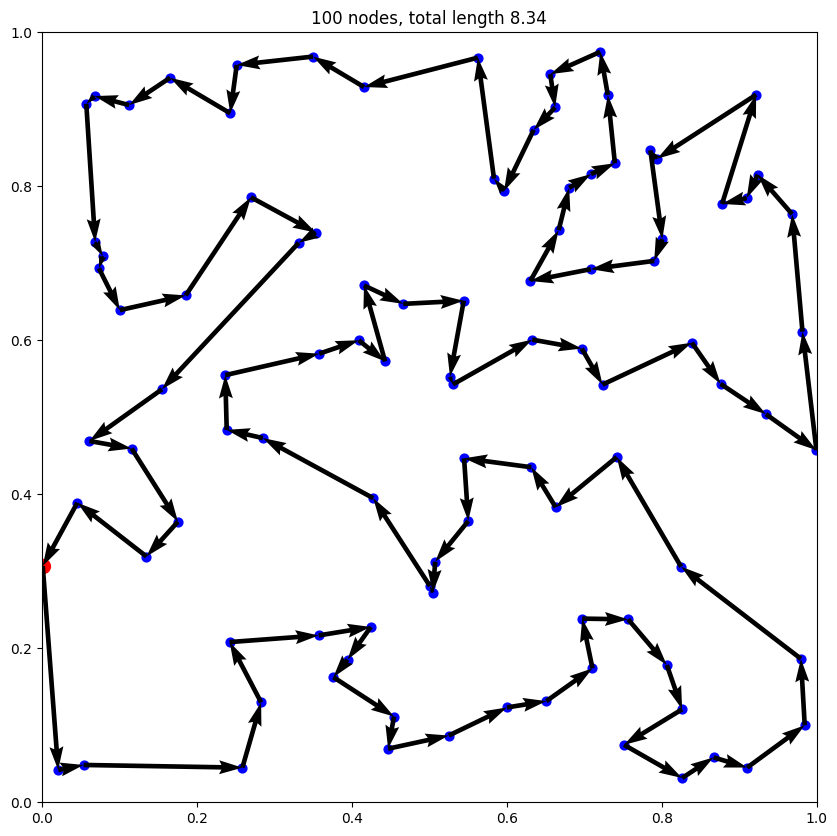

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))
    
fig, ax = plt.subplots(figsize=(10, 10))
plot_tsp(xy, tour, ax)

MovieWriter imagemagick unavailable; using Pillow instead.


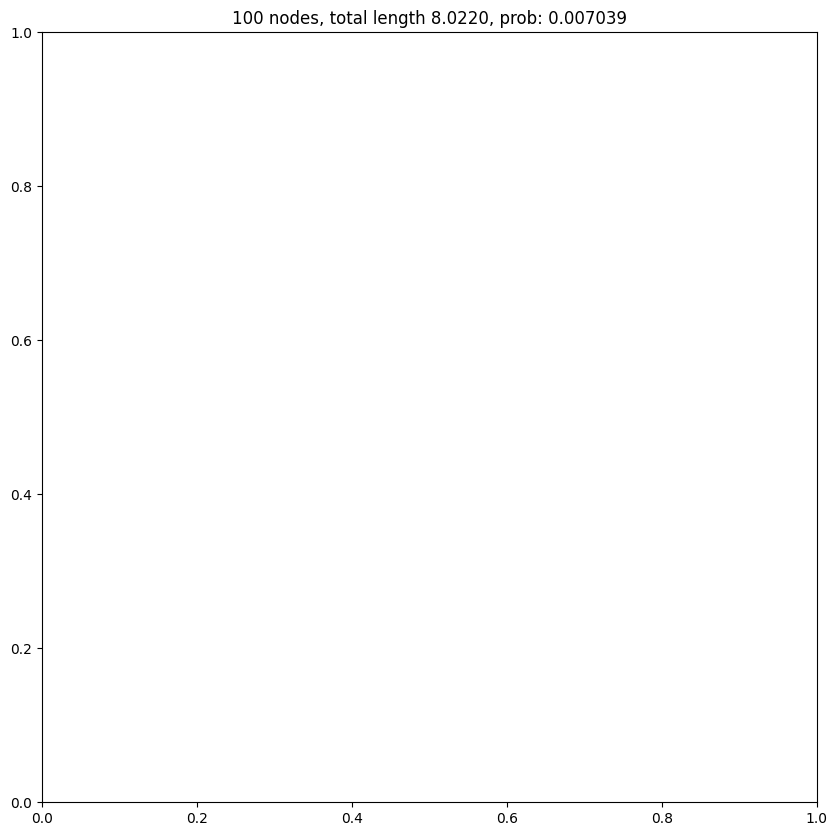

In [24]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import HTML

from celluloid import Camera  # pip install celluloid

def format_prob(prob):
    return ('{:.6f}' if prob > 1e-5 else '{:.2E}').format(prob)

def plot_tsp_ani(xy, tour, tour_p=None, max_steps=1000):
    n = len(tour)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    camera = Camera(fig)

    total_length = 0
    cum_log_prob = 0
    for i in range(n + 1):
        for plot_probs in [False] if tour_p is None or i >= n else [False, True]:
            # Title
            title = 'Nodes: {:3d}, length: {:.4f}, prob: {}'.format(
                i, lengths[i - 2] if i > 1 else 0., format_prob(np.exp(cum_log_prob))
            )
            ax1.text(0.6, 0.97, title, transform=ax.transAxes)

            # First print current node and next candidates
            ax1.scatter(xs, ys, s=40, color='blue')

            if i > 0:
                ax1.scatter([xs[i - 1]], [ys[i - 1]], s=100, color='red')
            if i > 1:
                qv = ax1.quiver(
                    xs[:i-1],
                    ys[:i-1],
                    dx[:i-1],
                    dy[:i-1],
                    scale_units='xy',
                    angles='xy',
                    scale=1,
                )
            if plot_probs:
                prob_rects = [Rectangle((x, y), 0.01, 0.1 * p) for (x, y), p in zip(xy, tour_p[i]) if p > 0.01]
                pc = PatchCollection(prob_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
                ax1.add_collection(pc)
            camera.snap()
        if i < n and tour_p is not None:
            # Add cumulative_probability
            cum_log_prob += np.log(tour_p[i][tour[i]])
        if i > max_steps:
            break

    # Plot final tour
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    if tour_p is not None:
        # Note this does not use stable logsumexp trick
        cum_log_prob = format_prob(np.exp(sum([np.log(p[node]) for node, p in zip(tour, tour_p)])))
    else:
        cum_log_prob = '?'
    ax1.set_title('{} nodes, total length {:.4f}, prob: {}'.format(len(tour), lengths[-1], cum_log_prob))
    
    camera.snap()
    
    return camera 

    
animation = plot_tsp_ani(xy, tour, tour_p).animate(interval=500)
animation.save('images/tsp.gif', writer='imagemagick', fps=2)  # requires imagemagick 
# compress by running 'convert tsp.gif -strip -coalesce -layers Optimize tsp.gif'
# HTML(animation.to_html5_video())  # requires ffmpeg